### This is an analysis which answers a set of questions based on sales data.<br/>
## Dataset
### This dataset consists of orders and the relevant order and customer details. In this case the data was provided in an Excel document with differnt tables on different sheets of the Excel workbook. Usually data with different tables that are related by a common ID would be encountered in a database. In this case I've had to import the different tables and join them in python.<br/>
## Questions
1. What is the total number of sales?
2. What is the eaverage sales per month?
3. What is the monthly revenue?
4. What are the key demographics of the customers?
5. Which county generated the most sales on average?
6. What were the profits per product per month?
7. When were the best and worst selling periods?
## Next Steps
### Once the metrics of interest are identified, productionising the script so that these metrics can be calculated by simply changing the input data should be the next step. Then, developing the infrastructure to feed this data to a cloud-based visualisation front end will make the consumption of this information for management a much smoother process. 

## 1. Import libraries and data

In [140]:
# data manipulation
import pandas as pd

# date manipulation
from datetime import datetime

# data viz
import matplotlib.pyplot as plt

In [49]:
# import the different data tables from an Excel workbook

sales = pd.read_excel('G:\\My Drive\\Regan-John Daniels System\\Career\\Improve Professional Profile\\Project 2 Sales Data Analysis\\US_Regional_Sales_Data.xlsx', sheet_name='Sales Orders Sheet', converters= {'OrderDate': pd.to_datetime})
customers = pd.read_excel('G:\\My Drive\\Regan-John Daniels System\\Career\\Improve Professional Profile\\Project 2 Sales Data Analysis\\US_Regional_Sales_Data.xlsx', sheet_name='Customers Sheet')
store_locations = pd.read_excel('G:\\My Drive\\Regan-John Daniels System\\Career\\Improve Professional Profile\\Project 2 Sales Data Analysis\\US_Regional_Sales_Data.xlsx', sheet_name='Store Locations Sheet')
products = pd.read_excel('G:\\My Drive\\Regan-John Daniels System\\Career\\Improve Professional Profile\\Project 2 Sales Data Analysis\\US_Regional_Sales_Data.xlsx', sheet_name='Products Sheet')
regions = pd.read_excel('G:\\My Drive\\Regan-John Daniels System\\Career\\Improve Professional Profile\\Project 2 Sales Data Analysis\\US_Regional_Sales_Data.xlsx', sheet_name='Regions Sheet')
sales_team = pd.read_excel('G:\\My Drive\\Regan-John Daniels System\\Career\\Improve Professional Profile\\Project 2 Sales Data Analysis\\US_Regional_Sales_Data.xlsx', sheet_name='Sales Team Sheet')

## 2. Pre-processing

In [50]:
# Join relevant tables
joined_data = sales.join(customers.set_index('_CustomerID'), on='_CustomerID', how='inner')
joined_data = joined_data.join(store_locations.set_index('_StoreID'), on='_StoreID', how='inner')
joined_data = joined_data.join(products.set_index('_ProductID'), on='_ProductID', how='inner')
joined_data = joined_data.join(regions.set_index(['StateCode', 'State']), on=['StateCode', 'State'], how='inner', rsuffix='_regions')
joined_data = joined_data.join(sales_team.set_index('_SalesTeamID'), on='_SalesTeamID', how='inner', rsuffix='_sales_team')

In [51]:
# View columns
joined_data.columns

Index(['OrderNumber', 'Sales Channel', 'WarehouseCode', 'ProcuredDate',
       'OrderDate', 'ShipDate', 'DeliveryDate', 'CurrencyCode', '_SalesTeamID',
       '_CustomerID', '_StoreID', '_ProductID', 'Order Quantity',
       'Discount Applied', 'Unit Price', 'Unit Cost', 'Customer Names',
       'City Name', 'County', 'StateCode', 'State', 'Type', 'Latitude',
       'Longitude', 'AreaCode', 'Population', 'Household Income',
       'Median Income', 'Land Area', 'Water Area', 'Time Zone', 'Product Name',
       'Region', 'Sales Team', 'Region_sales_team'],
      dtype='object')

#### Add columns: Split dates out into year and year-month

In [80]:
# split OrderDate into its 'year' component
joined_data['OrderYear'] = list(joined_data['OrderDate'].dt.year)

# split OrderDate into its year-month format
joined_data['OrderYearMonth'] = [x.strftime('%Y-%m') for x in joined_data['OrderDate']]

# split ShipDate into its 'year' component
joined_data['ShipYear'] = list(joined_data['ShipDate'].dt.year)

# split ShipDate into its year-month format
joined_data['ShipYearMonth'] = [x.strftime('%Y-%m') for x in joined_data['ShipDate']]

# split DeliveryDate into its 'year' component
joined_data['DeliveryYear'] = list(joined_data['DeliveryDate'].dt.year)

# split DeliveryDate into its year-month format
joined_data['DeliveryYearMonth'] = [x.strftime('%Y-%m') for x in joined_data['DeliveryDate']]

joined_data.head()

,OrderNumber,Sales Channel,WarehouseCode,ProcuredDate,OrderDate,ShipDate,DeliveryDate,CurrencyCode,_SalesTeamID,_CustomerID,...,Product Name,Region,Sales Team,Region_sales_team,OrderYear,OrderYearMonth,ShipYear,ShipYearMonth,DeliveryYear,DeliveryYearMonth
0,SO - 000101,In-Store,WARE-UHY1004,2017-12-31,2018-05-31,2018-06-14,2018-06-19,USD,6,15,...,Dining Furniture,Northeast,Joshua Bennett,Northeast,2018,2018-05,2018,2018-06,2018,2018-06
5065,SO - 0005166,In-Store,WARE-PUJ1005,2019-08-23,2020-01-22,2020-01-28,2020-01-31,USD,6,7,...,Dining Furniture,Northeast,Joshua Bennett,Northeast,2020,2020-01,2020,2020-01,2020,2020-01
6612,SO - 0006713,In-Store,WARE-UHY1004,2020-03-10,2020-07-21,2020-08-15,2020-08-16,USD,6,48,...,Computers,Northeast,Joshua Bennett,Northeast,2020,2020-07,2020,2020-08,2020,2020-08
6742,SO - 0006843,In-Store,WARE-PUJ1005,2020-03-10,2020-08-06,2020-08-14,2020-08-17,USD,6,32,...,Basketball,Northeast,Joshua Bennett,Northeast,2020,2020-08,2020,2020-08,2020,2020-08
4934,SO - 0005035,In-Store,WARE-UHY1004,2019-08-23,2020-01-08,2020-01-15,2020-01-21,USD,6,47,...,Cookware,Northeast,Joshua Bennett,Northeast,2020,2020-01,2020,2020-01,2020,2020-01


#### Add columns: Calculate total order values: Total value, total value before discount, total cost

In [87]:
# Calculate total order price after the discount has been deducted
joined_data['total_order_price_after_discount'] = joined_data['Unit Price'] * joined_data['Order Quantity'] - joined_data['Discount Applied']

# Calculate total order price before the discount has been deducted
joined_data['total_order_price_before_discount'] = joined_data['Unit Price'] * joined_data['Order Quantity']

# Calculate the cost price of the order 
joined_data['total_order_cost'] = joined_data['Unit Cost'] * joined_data['Order Quantity']

# Calculate the profit made on the order
joined_data['profit'] = joined_data['total_order_price_after_discount'] - joined_data['total_order_cost']

Index(['OrderNumber', 'Sales Channel', 'WarehouseCode', 'ProcuredDate',
       'OrderDate', 'ShipDate', 'DeliveryDate', 'CurrencyCode', '_SalesTeamID',
       '_CustomerID', '_StoreID', '_ProductID', 'Order Quantity',
       'Discount Applied', 'Unit Price', 'Unit Cost', 'Customer Names',
       'City Name', 'County', 'StateCode', 'State', 'Type', 'Latitude',
       'Longitude', 'AreaCode', 'Population', 'Household Income',
       'Median Income', 'Land Area', 'Water Area', 'Time Zone', 'Product Name',
       'Region', 'Sales Team', 'Region_sales_team', 'OrderYear',
       'OrderYearMonth', 'ShipYear', 'ShipYearMonth', 'DeliveryYear',
       'DeliveryYearMonth', 'total_order_price_after_discount',
       'total_order_price_before_discount', 'total_order_cost'],
      dtype='object')

### Add column: Bracket the household incomes

In [95]:
# Create the income bins and brackets
income_bins = [0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000]
income_labels = ['0-500k', '500k - 1m', '1m - 1.5m', '1.5m - 2m', '2m - 2.5m', '2.5m - 3m', '3m - 3.5m']

# Allocate the income bracket to a new column
joined_data['household_income_bracket'] = pd.cut(joined_data['Household Income'], bins=income_bins, labels=income_labels)

## 3. Addressing the questions

### Question
#### What is the total number of sales?

In [279]:
joined_data['OrderNumber'].nunique()

7991

### Answer
#### There were 7991 sales from May 2018 to December 2020
***

***
### Question
#### What is the average sales per month?

In [83]:
joined_data.groupby(['OrderYearMonth'])['OrderNumber'].nunique().mean()

249.71875

### Answer
#### There are an average of 250 sales per month
***

***
### Question
#### What is the monthly revenue?

In [226]:
# group data by month and sum the revenue
monthly_revenue = joined_data.groupby(['OrderYearMonth'])['total_order_price_after_discount'].sum().reset_index().set_index('OrderYearMonth')

# remove datapoint for May 2018 as it has a problem
monthly_revenue.drop('2018-05', inplace=True)

# Calculate the average monthly revenue
average_monthly_revenue = monthly_revenue['total_order_price_after_discount'].mean()

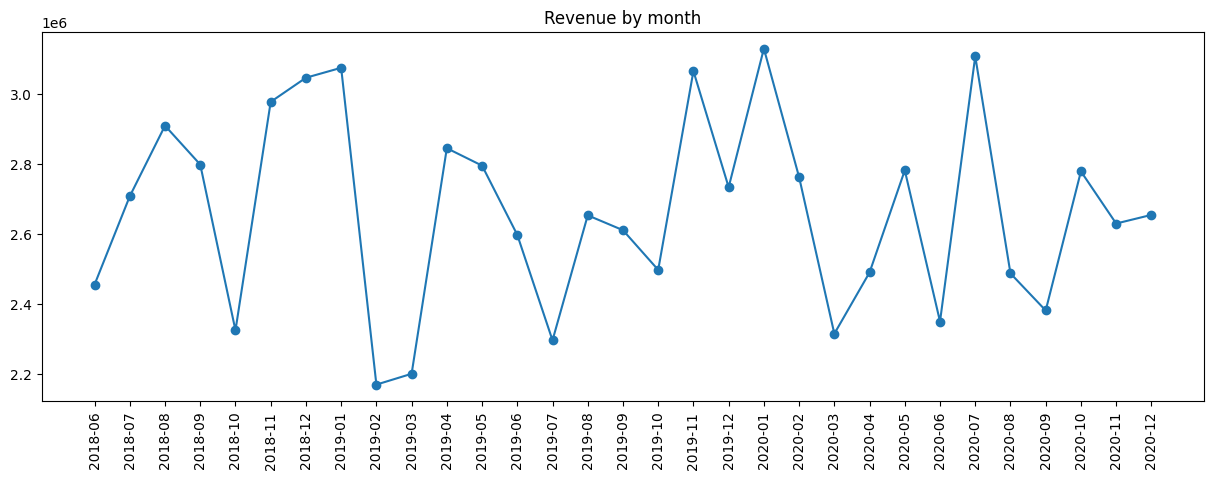

In [280]:
# plot the revenue by month
plt.figure().set_figwidth(15)
plt.xticks(rotation = 90)
plt.title("Revenue by month")
plt.plot(monthly_revenue, marker='o')

In [179]:
# Format the currency to be easier to read
monthly_revenue['total_order_price_after_discount'] = [f'R{"{:,.2f}".format(x)}' for x in monthly_revenue['total_order_price_after_discount']]
monthly_revenue

,total_order_price_after_discount
OrderYearMonth,
2018-06,"R2,454,722.80"
2018-07,"R2,707,520.90"
2018-08,"R2,909,389.45"
2018-09,"R2,798,165.65"
2018-10,"R2,323,695.38"
2018-11,"R2,977,579.18"
2018-12,"R3,046,583.90"
2019-01,"R3,075,079.23"
2019-02,"R2,168,543.60"


In [232]:
# Display average monthly revenue 
f'Average monthly revenue: R{"{:,.2f}".format(average_monthly_revenue)}'

'Average monthly revenue: R2,665,038.18'

### Answer
#### The above chart and table displays the monthly revenue figures<br/>The average monthly revenue is R2.65m
*** 

***
### Question
#### What are the key demographics of the customers?
> household income<br/>
> state

In [219]:
# Group data by income bracket and count unique number of customer ID
customer_income = joined_data.groupby(['household_income_bracket'])['_CustomerID'].nunique().reset_index()

Index(['household_income_bracket', '_CustomerID'], dtype='object')

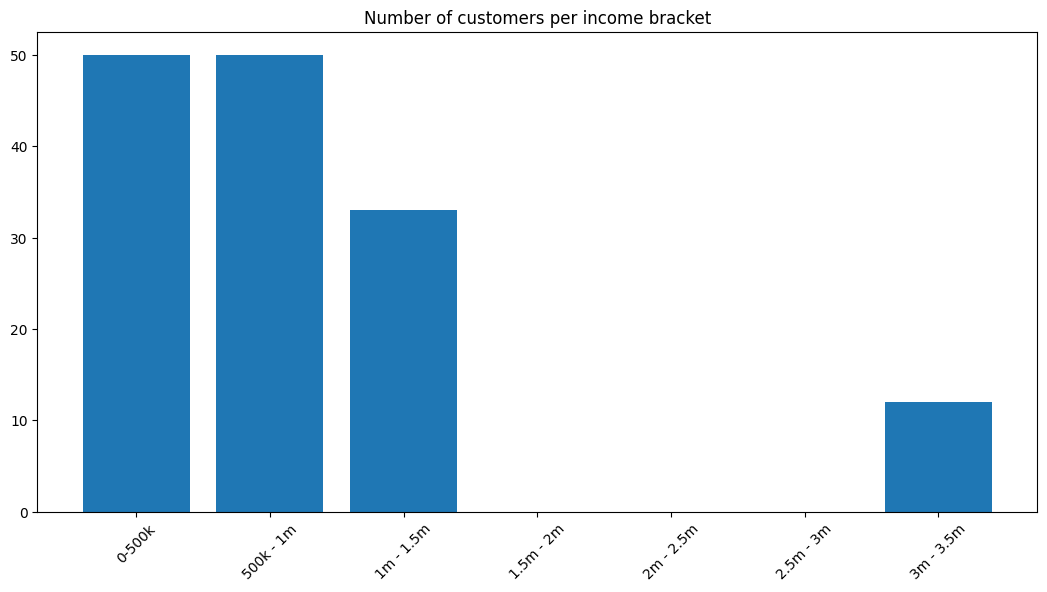

In [277]:
# Display number of customers per income bracket
fig = plt.figure()
fig.set_figwidth(10)
ax = fig.add_axes([0,0,1,1])
ax.bar(customer_income['household_income_bracket'], customer_income['_CustomerID'])
plt.xticks(rotation = 45)
plt.title('Number of customers per income bracket')
plt.show()

In [224]:
# Group data by state and count the unique number of customers per state
state_customers = joined_data.groupby(['State'])['_CustomerID'].nunique().reset_index().sort_values('_CustomerID', ascending=False)

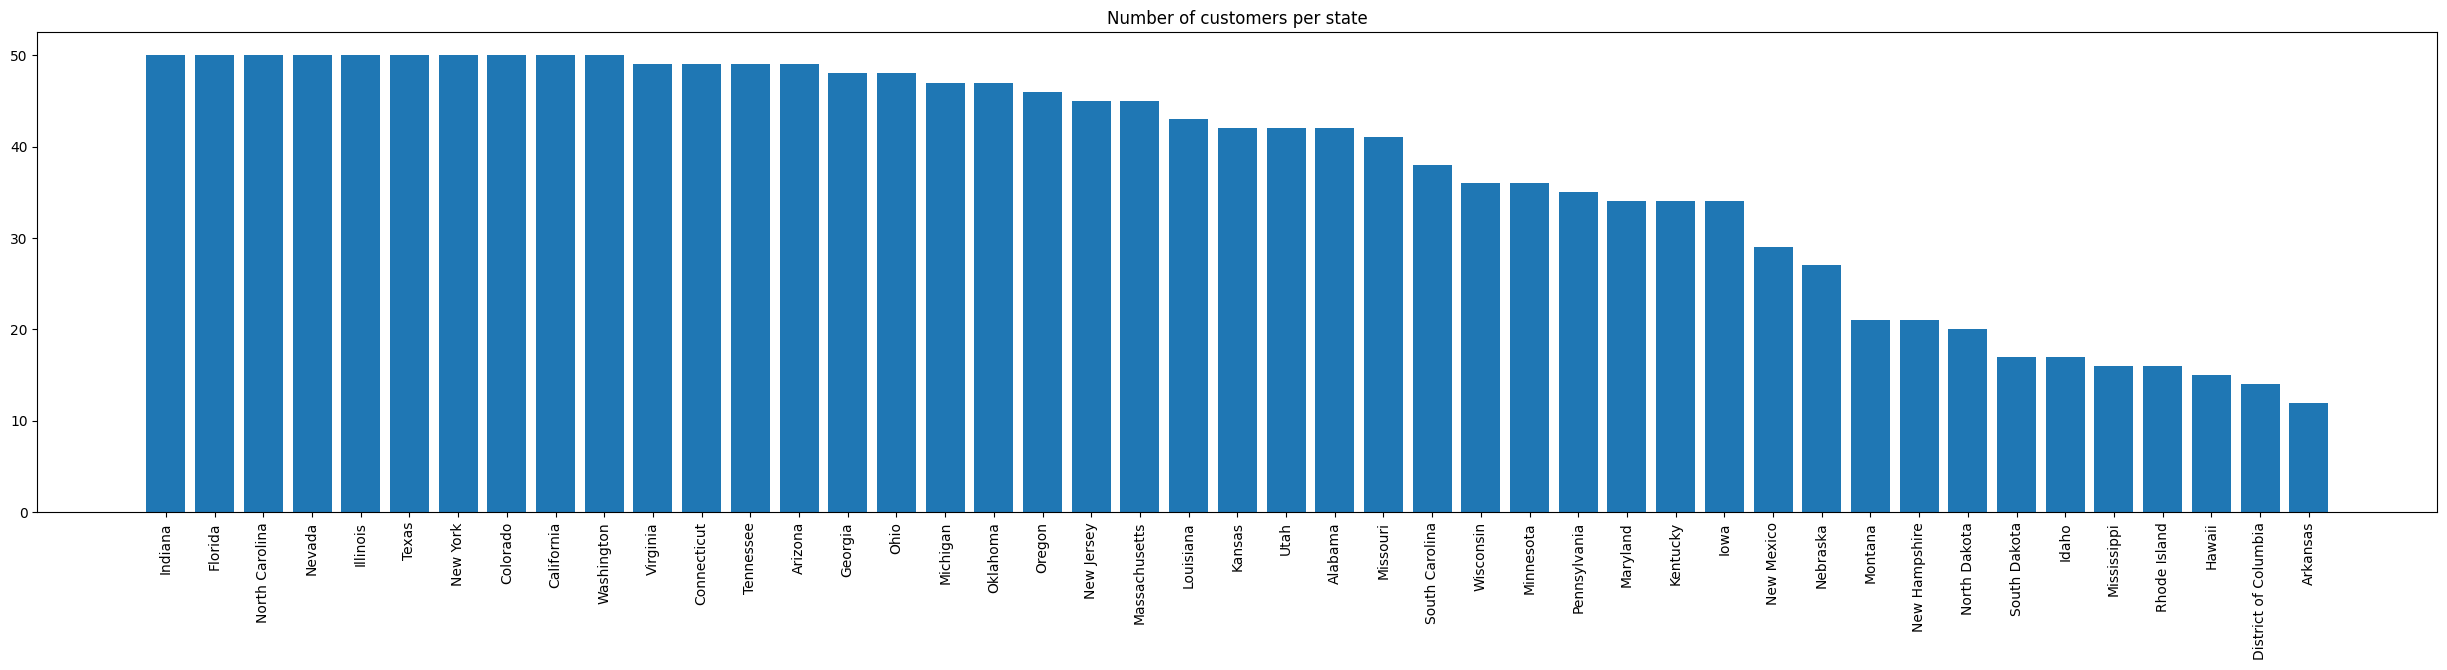

In [276]:
# Display number of customers per state
fig = plt.figure()
fig.set_figwidth(24)
ax = fig.add_axes([0,0,1,1])
ax.bar(state_customers['State'], state_customers['_CustomerID'])
plt.xticks(rotation = 90)
plt.title('Number of customers per state')
plt.show()

### Answer
#### The key demographics in this dataset are the income and location of customers.<br/>Above are charts which segment the number of customers by their income level and the state in which they are located.
***

***
### Question
#### Which county generated the most sales on average per month?

In [281]:
# Group data by County and month and count number of orders, then group by only county and calculate the mean across months for each county
county_sales = joined_data.groupby(['County', 'OrderYearMonth'])['OrderNumber'].nunique().reset_index().groupby('County')['OrderNumber'].mean().reset_index().sort_values('OrderNumber', ascending=False)
top5_county_sales = county_sales.head(5)

In [282]:
top5_county_sales

,County,OrderNumber
117,Los Angeles County,11.258065
43,Cook County,6.774194
148,Orange County,6.516129
179,San Diego County,6.333333
121,Maricopa County,5.437500


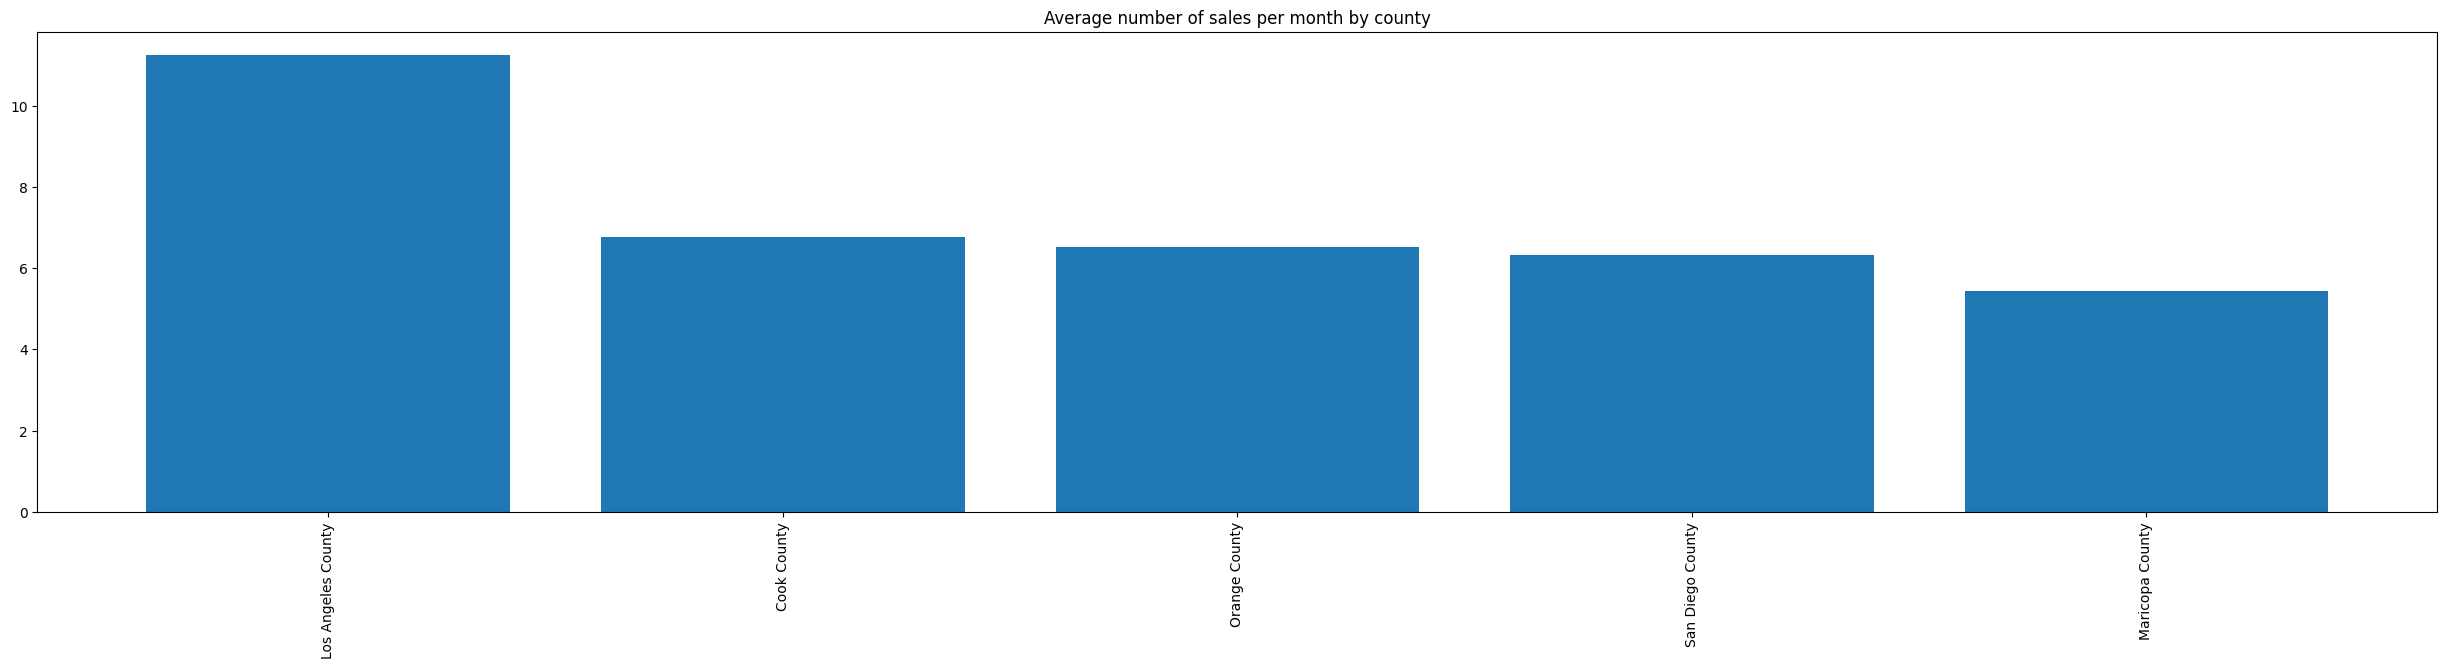

In [283]:
# Display number of sales per month by county
fig = plt.figure()
fig.set_figwidth(24)
ax = fig.add_axes([0,0,1,1])
ax.bar(top5_county_sales['County'], top5_county_sales['OrderNumber'])
plt.xticks(rotation = 90)
plt.title('Average number of sales per month by county')
plt.show()

### Answer
#### We can see that Los Angeles County is well ahead of the pack with 11 sales on average per month followed by Cook county with ~7 sales on average per month
***

***
### Question
#### What were the profits per product by month?

In [264]:
# Group data by Month and Product Name and calculate the sum of profit
segment_profit = joined_data.groupby(['OrderYearMonth', 'Product Name'])['profit'].sum().reset_index().sort_values(['OrderYearMonth', 'profit'], ascending=False)
segment_profit

,OrderYearMonth,Product Name,profit
1436,2020-12,Furniture Cushions,45653.029
1420,2020-12,Bathroom Furniture,45341.177
1425,2020-12,Candles,45124.974
1453,2020-12,Table Linens,41232.685
1441,2020-12,Outdoor Furniture,39164.300
...,...,...,...
2,2018-05,Candles,2769.948
1,2018-05,Bathroom Furniture,2623.570
7,2018-05,Wreaths,1772.745
5,2018-05,Sculptures,1452.510


In [270]:
## Extract 5 products to focus on

# Get list of 5 products
random_products = list(segment_profit['Product Name'].unique())[0:5]
# Filter the df for the above list of products
top5_segment_profit = segment_profit[segment_profit['Product Name'].isin(random_products)]

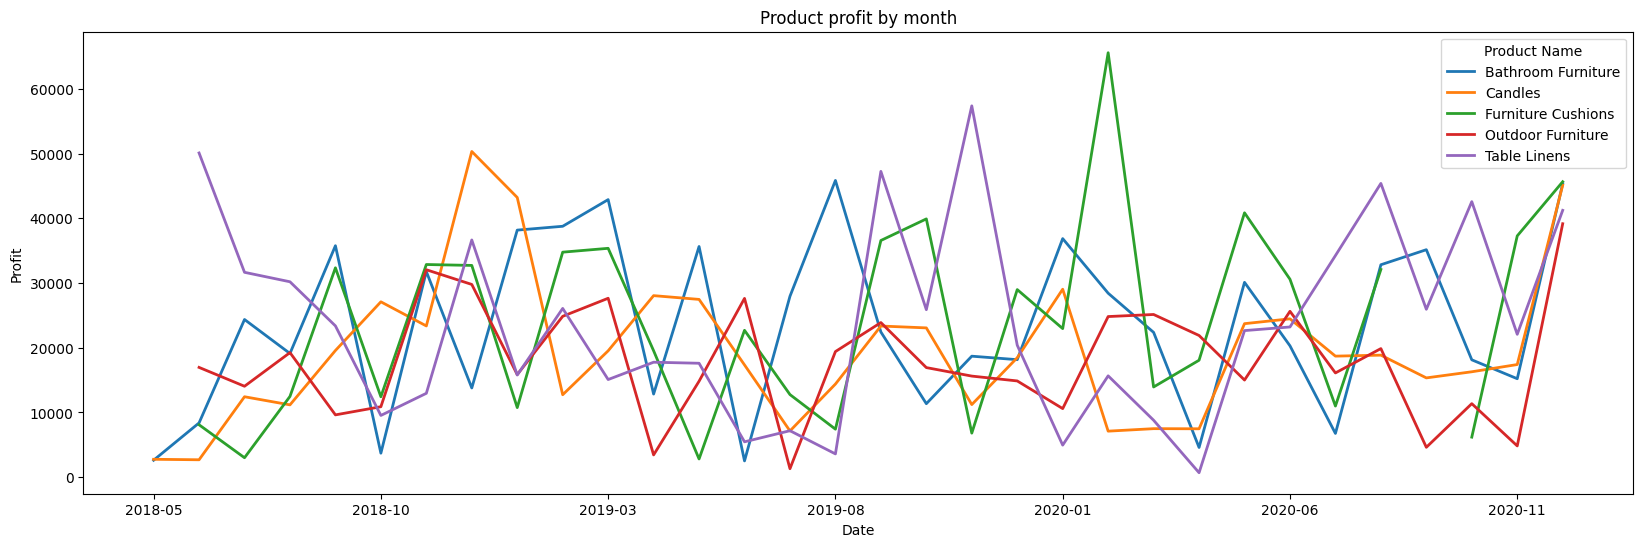

In [278]:
# Display product profit by month
df_pivot = top5_segment_profit.pivot(index='OrderYearMonth', columns='Product Name', values='profit')

# create a line chart with a different color for each product's sales
ax = df_pivot.plot(kind='line', figsize=(20, 6), linewidth=2)

# set the chart title and axis labels
ax.set_title("Product profit by month")
ax.set_xlabel("Date")
ax.set_ylabel("Profit")

# display the chart
plt.show()

### Answer
#### The above chart displays profit per month for 5 products. The chart wuold get be too messy if all products are included. Specific products can be included or excluded above
***

***
## Question:
#### When were the best and worst selling periods?

In [158]:
# Group data by month and order number and count number of orders
best_worst = joined_data.groupby(['OrderYearMonth'])['OrderNumber'].nunique().reset_index().sort_values('OrderYearMonth', ascending=True).set_index('OrderYearMonth')
# remove data for May 2018
best_worst = best_worst.drop('2018-05')

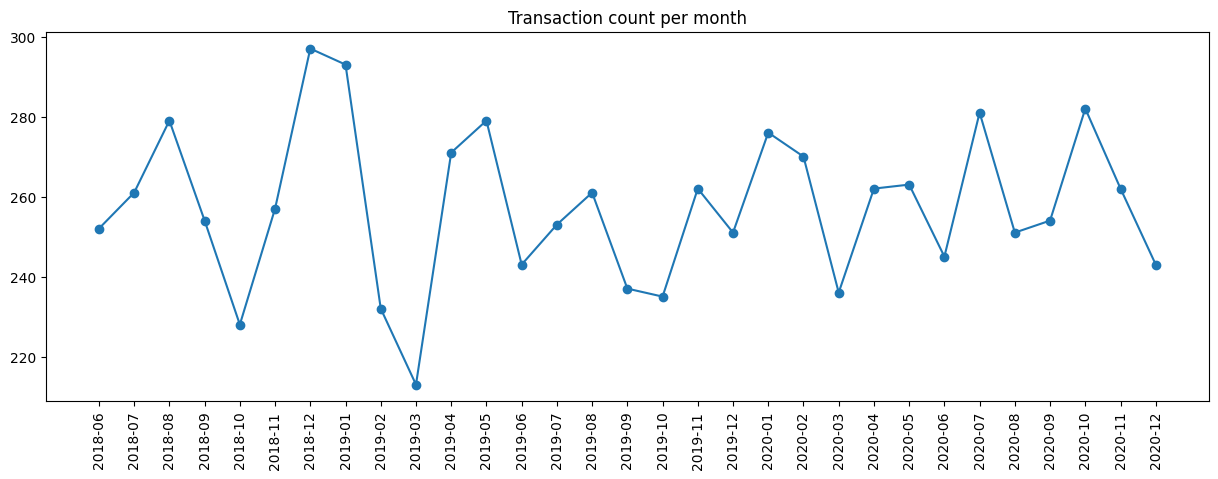

In [275]:
# Display transaction count per month
plt.figure().set_figwidth(15)
plt.xticks(rotation = 90)
plt.title("Transaction count per month")
plt.plot(best_worst, marker='o')


## Answer:
#### From this we can see that the worst selling period was March 2019 and the best selling period was December 2018
***